## linear operator test

In [134]:
import numpy as np
from scipy.sparse.linalg import LinearOperator, eigsh
from scipy.stats import beta
from graspologic.simulations import sbm
from graspologic.utils import to_laplacian

def make_community(a, b, n=500):
    return beta.rvs(a, b, size=(n, 5))

def gen_covariates(n):
    c1 = make_community(2, 5, n=n)
    c2 = make_community(2, 2, n=n)

    covariates = np.vstack((c1, c2))
    return covariates
    
# make SBM
n = 5000
P = np.array([[.8, .2], [.2, .8]])
A, labels = sbm([n, n], P, return_labels=True)

# Generate a covariate matrix
Y = gen_covariates(n=n)

true eigenvalues

# Test speed increase in calculating leading eigenvalues

In [75]:
%%timeit

L = to_laplacian(A, form="R-DAD")
YYt = Y@Y.T

L_top_slow = eigsh(L, k=1, return_eigenvectors=False)**2
YYt_top_slow = eigsh(YYt, k=1, return_eigenvectors=False)

33.9 s ± 1.46 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [76]:
L = to_laplacian(A, form="R-DAD")
YYt = Y@Y.T

L_top_slow = eigsh(L, k=1, return_eigenvectors=False)**2
YYt_top_slow = eigsh(YYt, k=1, return_eigenvectors=False)

In [77]:
%%timeit

def matvec(v):
    return Y@(Y.T@v)
    
LO = LinearOperator((Y.shape[0], Y.shape[0]), matvec=matvec)

L_top_fast = eigsh(L, k=1, return_eigenvectors=False)**2
YYt_top_fast = eigsh(LO, k=1, return_eigenvectors=False)

609 ms ± 2.94 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
def matvec(v):
    return Y@(Y.T@v)
    
LO = LinearOperator((Y.shape[0], Y.shape[0]), matvec=matvec)

L_top_fast = eigsh(L, k=1, return_eigenvectors=False)**2
YYt_top_fast = eigsh(LO, k=1, return_eigenvectors=False)

In [79]:
print(f"{83.3 / 5.78} times speed increase")

14.411764705882351 times speed increase


#### Eigenvalues are the same

In [80]:
YYt_top_slow = eigsh(YYt, k=1, return_eigenvectors=False)
YYt_top_fast = eigsh(LO, k=1, return_eigenvectors=False)

print(YYt_top_slow)
print(YYt_top_fast)

[50041.04838588]
[50041.04838588]


## Test speed increase in embedding matrix

In [90]:
%%timeit 

from sklearn.utils.extmath import randomized_svd

L_ = L + Y@Y.T
D_slow, U_slow = eigsh(L_, k=2)

3.04 s ± 222 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [91]:
from sklearn.utils.extmath import randomized_svd

L_ = L + Y@Y.T
D_slow, U_slow = eigsh(L_, k=2)

In [92]:
%%timeit

def _matvec(v):
    return (L@v) + Y@(Y.T@v)

L_ = LinearOperator((10000, 10000), matvec=_matvec)
D_fast, U_fast = eigsh(L_, k=2)

2.17 s ± 175 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [93]:
print(f"{3.04/2.17} speed increase on 10,000 node matrix")

1.4009216589861753 speed increase on 10,000 node matrix


## Profiling speed as a function of node size

In [133]:
def gen_network(n):
    P = np.array([[.8, .2], [.2, .8]])
    A = sbm([n//2, n//2], P)
    Y = gen_covariates(n=n//2)
    return A, Y

A, Y = gen_network(10)

(10, 30)

In [187]:
np.set_printoptions(suppress=True)
from time import time

def gen_network(n):
    P = np.array([[.08, .02], [.02, .08]])
    A = sbm([n//2, n//2], P)
    Y = gen_covariates(n=n//2)
    return A, Y

def _matvec(v):
    return (L@v) + Y@(Y.T@v)

nodes = np.geomspace(100, 10000, 20).astype(int)
nodes[nodes % 2 == 1] += 1

slows = {}
fasts = {}
for n in nodes:
    A, Y = gen_network(n)
    L = to_laplacian(A, form="R-DAD")
    
    # calculating Y@Y.T
    start = time()
    L_ = L + Y@Y.T
    D, U = eigsh(L_, k=2)
    slows[n] = time() - start
    
    # as LinearOperator
    start = time()
    L_ = LinearOperator((n, n), matvec=_matvec)
    D, U = eigsh(L_, k=2)
    fasts[n] = time() - start

#### Embedding down to 2 dimensions. P=[[.08, .02], [.02, .08]].

[Text(0.5, 1.0, 'Speed comparison of Lanczos algorithm compared to calculating $YY^\\top$')]

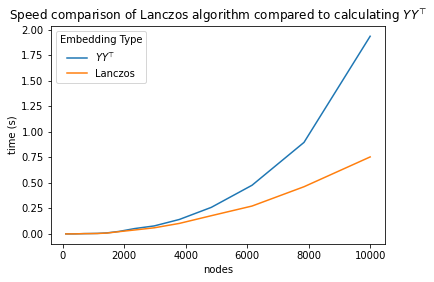

In [188]:
import pandas as pd
import seaborn as sns

times = slows.copy()
df = pd.DataFrame(times.values(), index=times.keys(), columns=["Slow"])
df.reset_index(inplace=True)

df["Fast"] = fasts.values()
melted = pd.melt(df, id_vars="index")
melted.rename(columns={"index": "nodes", "variable": "Embedding Type", "value": "time (s)"},
              inplace=True)
melted.head()
melted["Embedding Type"].replace({"Slow": r"$YY^\top$", "Fast": "Lanczos"}, inplace=True)
ax = sns.lineplot(data=melted, x="nodes", y="time (s)", hue="Embedding Type")
ax.set(title=r"Speed comparison of Lanczos algorithm compared to calculating $YY^\top$")